In [81]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
plt.style.use("dark_background")
np.random.seed(2025)


In [82]:
A, B = "GC=F", "SI=F"   # tickers
PERIOD = "5y"
LAGS = 20                       # +/- lag days to check
ROLL = 60                       # rolling window days

In [83]:
def get_close(tk):
    df = yf.download(tk, period=PERIOD, progress=False, auto_adjust=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    return df[col].dropna().sort_index()   # oldest->newest

x = get_close(A); y = get_close(B)
data = pd.concat([x,y], axis=1, join="inner").dropna(); data.columns = ["A","B"]
r = np.log(data / data.shift(1)).dropna()


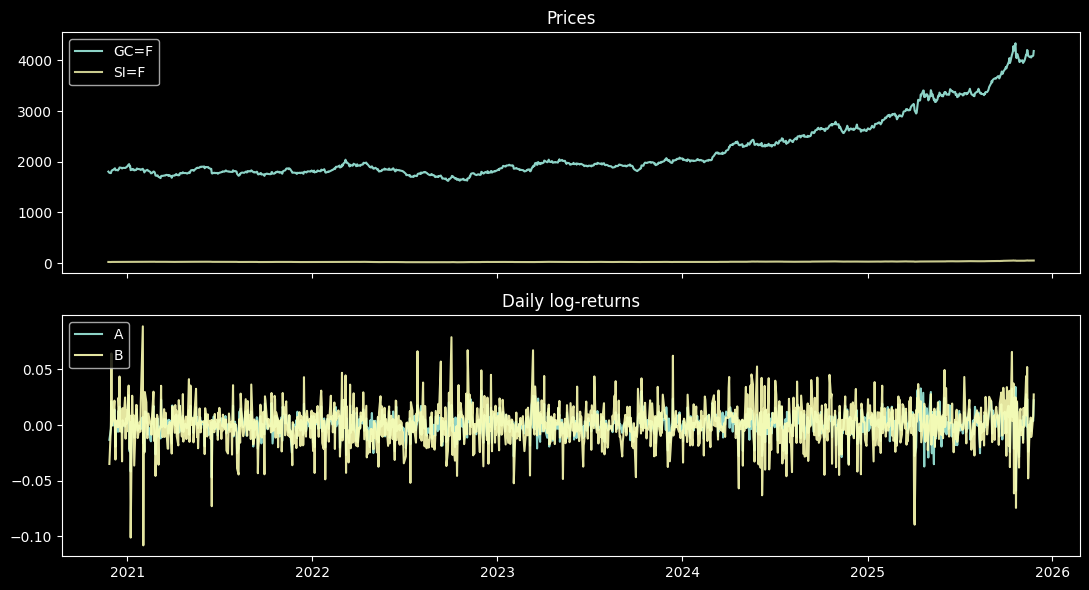

In [84]:
fig, ax = plt.subplots(2,1,figsize=(11,6), sharex=True)
ax[0].plot(data.index, data["A"], label=A); ax[0].plot(data.index, data["B"], label=B, alpha=0.8)
ax[0].legend(loc="upper left"); ax[0].set_title("Prices")
ax[1].plot(r.index, r["A"], label="A"); ax[1].plot(r.index, r["B"], label="B", alpha=0.9)
ax[1].legend(loc="upper left"); ax[1].set_title("Daily log-returns")
plt.tight_layout(); plt.show()

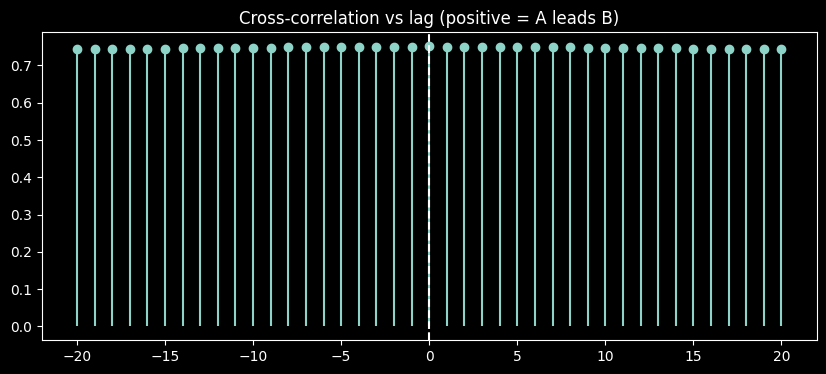

Top 5 correlation peaks:
1.  lag =   0   corr =  0.7516   |corr| =  0.7516
2.  lag =   2   corr =  0.7507   |corr| =  0.7507
3.  lag =  -2   corr =  0.7507   |corr| =  0.7507
4.  lag =   1   corr =  0.7507   |corr| =  0.7507
5.  lag =  -1   corr =  0.7507   |corr| =  0.7507


In [85]:
def cross_corr_simple(a, b, L):
    lags = np.arange(-L, L+1)
    vals = []
    for lag in lags:
        if lag < 0:    vals.append(a[:lag].corr(b[-lag:]))
        elif lag > 0:  vals.append(a[lag:].corr(b[:-lag]))
        else:          vals.append(a.corr(b))
    return lags, np.array(vals)

lags, vals = cross_corr_simple(r["A"], r["B"], LAGS)
plt.figure(figsize=(10,4)); plt.stem(lags, vals, basefmt=" ")
plt.axvline(0,color="white",ls="--"); plt.title("Cross-correlation vs lag (positive = A leads B)"); plt.show()
top5 = sorted([(abs(v), v, int(l)) for v, l in zip(vals, lags)], reverse=True)[:5]

print("Top 5 correlation peaks:")
for i, (abs_corr, corr, lag) in enumerate(top5, 1):
    print(f"{i}.  lag = {lag:>3d}   corr = {corr:>7.4f}   |corr| = {abs_corr:>7.4f}")


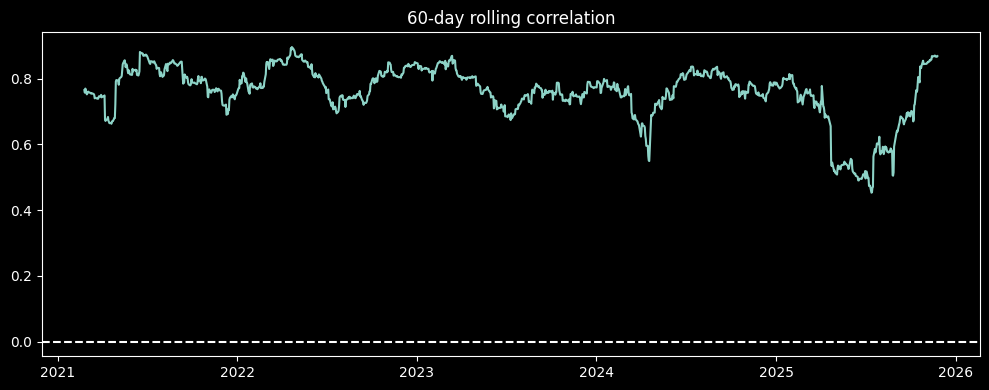

In [86]:
roll = r["A"].rolling(ROLL).corr(r["B"])
plt.figure(figsize=(10,4)); plt.plot(roll); plt.axhline(0,color="white",ls="--")
plt.title(f"{ROLL}-day rolling correlation"); plt.tight_layout(); plt.show()

In [87]:
def perm_pval(a,b,lag,n=1000):
    obs = (a[:lag].corr(b[-lag:]) if lag<0 else (a[lag:].corr(b[:-lag]) if lag>0 else a.corr(b)))
    count=0
    vals = b.values.copy()
    for _ in range(n):
        np.random.shuffle(vals)
        bsh = pd.Series(vals, index=b.index)
        sim = (a[:lag].corr(bsh[-lag:]) if lag<0 else (a[lag:].corr(bsh[:-lag]) if lag>0 else a.corr(bsh)))
        if abs(sim) >= abs(obs): count+=1
    return obs, (count+1)/(n+1)

In [88]:
best_lag = lags[np.argmax(np.abs(vals))]
print("Best lag:", best_lag, "corr:", round(vals.max() if best_lag==lags[np.argmax(vals)] else vals[np.argmax(np.abs(vals))],4))
obs,p = perm_pval(r["A"], r["B"], best_lag, n=500); print("perm p-value:", p)

Best lag: 0 corr: 0.7516
perm p-value: 0.001996007984031936
